In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
pd.options.display.max_rows = 10
pd.options.display.max_columns = 40

In [84]:
# allow google colab to read google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import Data & Clean

In [85]:
# take a glimpse of the columns that are imported
data_all_cols = pd.read_hdf('/content/drive/My Drive/quarterly_sample.h5',start=0,stop=1)
data_all_cols.columns

Index(['loan seq num', 'period', 'default', 'prepay', 'credit score',
       'curr upb', 'upb_prev', 'loan age', 'first time homebuyer flag',
       'channel', 'num of borrowers', 'loan purpose', 'dti', 'mi percent',
       'orig interest rate', 'prev ltv', 'ltv', 'Housing Starts',
       'Housing Starts_orig', 'Building Permits', 'Building Permits_orig',
       'New Home Sales', 'New Home Sales_orig', 'Existing Home Sales',
       'Existing Home Sales_orig', 'OECD Leading Indicator YoY', 'SP500 YoY',
       'Treasury 1yr', 'Treasury 1yr_orig', 'Treasury 30yr',
       'Treasury 30yr_orig', 'State Unemployment Rate',
       'State Unemployment Rate_orig', 'Real GDP YoY', 'ZillowHouseValue',
       'ZillowHouseValue_orig', '30yr Fixed Rate Mortgage Average'],
      dtype='object')

In [0]:
# import data
# do not import MI Percent since there are so many NA values
all_vars = [
    'loan seq num', 'period', 'default', 'prepay', 'channel','curr upb', 'upb_prev','num of borrowers',
       'loan age', 'credit score',  'dti', 'ltv',
       'orig interest rate', 'loan purpose',
       'prev ltv', 'Housing Starts','Housing Starts_orig',
       'Building Permits', 'Building Permits_orig','New Home Sales','New Home Sales_orig',
       'Existing Home Sales','Existing Home Sales_orig',
       'OECD Leading Indicator YoY', 'Treasury 1yr','Treasury 1yr_orig',
       'Treasury 30yr','Treasury 30yr_orig', 'State Unemployment Rate','State Unemployment Rate_orig', 'Real GDP YoY',
       'ZillowHouseValue','ZillowHouseValue_orig','30yr Fixed Rate Mortgage Average','SP500 YoY']


data_all = pd.read_hdf('/content/drive/My Drive/quarterly_sample.h5',columns=all_vars)

# drop records where the credit score is NA
data_all = data_all.dropna(subset=['credit score'])
data_all = data_all[data_all['credit score']<9999]

In [87]:
data_all.shape

(3158953, 35)

In [88]:
# drop anything left that is NA
data_all=data_all.dropna()

data_all.shape

(3082082, 35)

In [0]:
# sampling
# create a training and test set where the proportion of
# defaulted loans is the same in both sets

def sampling(size, df):
    non_defaults = df[~df['loan seq num'].isin(df[df.default == 1]['loan seq num'].unique())]
    defaults = df[df['loan seq num'].isin(df[df.default == 1]['loan seq num'].unique())]
    mortgage_count_n = non_defaults.groupby('loan seq num')['period'].count()
    mortgage_weights_n = mortgage_count_n/np.sum(mortgage_count_n)
    np.random.seed(seed=1)
    sample_index_n = np.random.choice(mortgage_count_n.index, int(size*non_defaults.shape[0]/np.average(mortgage_count_n, weights=mortgage_weights_n)), replace=False, p=mortgage_weights_n)
    mortgage_count_y = defaults.groupby('loan seq num')['period'].count()
    mortgage_weights_y = mortgage_count_y/np.sum(mortgage_count_y)
    np.random.seed(seed=1)
    sample_index_y = np.random.choice(mortgage_count_y.index, int(size*defaults.shape[0]/np.average(mortgage_count_y, weights=mortgage_weights_y)), replace=False, p=mortgage_weights_y)
    sample = df[df['loan seq num'].isin(sample_index_n) | df['loan seq num'].isin(sample_index_y)]
    out_sample = df[~df['loan seq num'].isin(sample_index_n) & ~df['loan seq num'].isin(sample_index_y)]
    return sample,out_sample

In [0]:
data_all_train,data_all_test = sampling(.7,data_all)  

In [91]:
print(data_all_train.shape)
print(data_all_test.shape)

(1931889, 35)
(1150193, 35)


#### Transform Variables

In [0]:
def create_X_y_matrix(dataset):
  # To get rid of annoying warning

  X = dataset[all_vars]

  y = X[['default','prepay']]
  y['nothing'] = 1-y['default']-y['prepay']

  # Transformed Variables

  # takes min of loan age or 120 (to make sure squared terms don't diverge)
  X['loan age'] = X[['loan age']].clip_upper(120)

  X['loan age squared'] = X['loan age']**2
  X['loan_age_cubed'] = X['loan age']**3
  X['30yr_diff'] = X['Treasury 30yr'] - X['Treasury 30yr_orig']
  X['1yr_diff'] = X['Treasury 1yr'] - X['Treasury 1yr_orig']
  X['ZillowHouseChg'] = X['ZillowHouseValue']/X['ZillowHouseValue_orig']
  X['State Unemployment Rate Squared'] = X['State Unemployment Rate']**2
  X['purpose_purchase'] = (X['loan purpose']=='P')*1
  X['purpose_cashout'] = (X['loan purpose']=='C')*1
  X['2_borrowers'] = (X['num of borrowers']==2)*1
  X['chan_broker'] = (X['channel']=='B')*1
  X['chan_correspondent'] = (X['channel']=='C')*1
  X['chan_not_specified'] = (X['channel']=='T')*1
  X['Housing Start_diff'] = X['Housing Starts']-X['Housing Starts_orig']
  X['Building Permits_diff'] = X['Building Permits']-X['Building Permits_orig']
  X['New Home Sales_diff'] = X['New Home Sales']-X['New Home Sales_orig']
  X['Existing Home Sales_diff'] = X['Existing Home Sales']-X['Existing Home Sales_orig']
  X['State Unemployment Rate_diff'] = X['State Unemployment Rate']-X['State Unemployment Rate_orig']
  
  return X, y


In [93]:
create_X_y_matrix(data_all_train)[0].columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Index(['loan seq num', 'period', 'default', 'prepay', 'channel', 'curr upb',
       'upb_prev', 'num of borrowers', 'loan age', 'credit score', 'dti',
       'ltv', 'orig interest rate', 'loan purpose', 'prev ltv',
       'Housing Starts', 'Housing Starts_orig', 'Building Permits',
       'Building Permits_orig', 'New Home Sales', 'New Home Sales_orig',
       'Existing Home Sales', 'Existing Home Sales_orig',
       'OECD Leading Indicator YoY', 'Treasury 1yr', 'Treasury 1yr_orig',
       'Treasury 30yr', 'Treasury 30yr_orig', 'State Unemployment Rate',
       'State Unemployment Rate_orig', 'Real GDP YoY', 'ZillowHouseValue',
       'ZillowHouseValue_orig', '30yr Fixed Rate Mortgage Average',
       'SP500 YoY', 'loan age squared', 'loan_age_cubed', '30yr_diff',
       '1yr_diff', 'ZillowHouseChg', 'State Unemployment Rate Squared',
       'purpose_purchase', 'purpose_cashout', '2_borrowers', 'chan_broker',
       'chan_correspondent', 'chan_not_specified', 'Housing Start_diff',
    

#### Fit Regularized MNLogit

This will fit the model by relying on regularization for variable selection

In [0]:
import statsmodels.api as st
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [0]:
# this function properly sets up the deisgn matrix and regularization
# penalties for conducting multinomial logistic regression

def setup_MN_variables(train_or_test,large_penalty,small_penalty):

  if train_or_test == 'train':
    X,y = create_X_y_matrix(data_all_train)
  else:
    X,y = create_X_y_matrix(data_all_test)
  
  # Define the variables to be used
  mn_vars = ['loan age', 'credit score',  'dti', 'ltv','orig interest rate',
            'Housing Starts','Building Permits','New Home Sales','Existing Home Sales','OECD Leading Indicator YoY', 
             'Treasury 1yr','Treasury 30yr', 'State Unemployment Rate', 'Real GDP YoY','ZillowHouseValue',
             '30yr Fixed Rate Mortgage Average','SP500 YoY', '2_borrowers','loan age squared','loan_age_cubed',
             '30yr_diff','1yr_diff','ZillowHouseChg','State Unemployment Rate Squared','purpose_purchase',
             'purpose_cashout','chan_broker','chan_correspondent','chan_not_specified','Housing Start_diff',
             'Building Permits_diff','New Home Sales_diff','Existing Home Sales_diff','State Unemployment Rate_diff']


  #Initial Regularization Penalty - ALL VARIABLES
  alpha_penalty = np.concatenate((np.array([0]),
                                  np.repeat(small_penalty,34))) # penalty for default variables
  alpha_penalty = np.concatenate((alpha_penalty,np.array([0]),
                                  np.repeat(small_penalty,34))) # penalty for prepay variables

  X_MN = X[mn_vars]
  X_MN = X[mn_vars].T.groupby(level=0).first().T
  X_MN = X_MN[mn_vars]

  # Scale the design matrix
  scaler = StandardScaler()
  X_MN = pd.DataFrame(scaler.fit_transform(X_MN), columns=X_MN.columns)
  X_MN.index = y.index

  # Insert constant term
  X_MN.insert(0, 'constant', 1)
  mn_vars = list(X_MN.columns.values)

  # Define target vector
  y_MN = y['default']+2*y['prepay']
  
  return X_MN, y_MN, mn_vars, alpha_penalty

In [0]:
# this runs multinomial logistc regression and 
# returns the model

def run_MN_regression(X_MN,y_MN,alpha_penalty):

  # Fit the model
  mdl = st.MNLogit(y_MN, X_MN)
  mdl_fit = mdl.fit_regularized(method='l1_cvxopt_cp',alpha=alpha_penalty,maxiter=15,
                                trim_mode='size',size_trim_tol=0.01)
  
  return mdl_fit

In [0]:
# calculates the average log likelihood of the model
# on the dataset (a measure of performance)

def calc_avg_log_like(mdl,y,X_MN):
  # calculate the log likelihood
  predictions = mdl.predict(X_MN)

  outcomes = pd.DataFrame()
  outcomes[0] = (y==0)*1
  outcomes[1] = (y==1)*1
  outcomes[2] = (y==2)*1

  avg_log_like_full = np.sum(np.log(np.sum(outcomes*predictions,axis=1)))/outcomes.shape[0]

  return avg_log_like_full

In [0]:
# this model returns the results from one run of multinomial logistic
# regression by calling the above functions

def results_one_model(alpha_large_penalty,alpha_small_penalty):
  # transform training variables
  X_MN,y_MN,mn_vars,alpha_penalty = setup_MN_variables('train',alpha_large_penalty,alpha_small_penalty)
  
  # fit model
  mdl_fit = run_MN_regression(X_MN,y_MN,alpha_penalty)
  
  # train log_likelihoods
  train_avg_ll = mdl_fit.llf/X_MN.shape[0]
  
  # transform testing variables
  X_MN,y_MN,mn_vars,alpha_penalty = setup_MN_variables('test',alpha_large_penalty,alpha_small_penalty)
  
  # test log likelihood
  test_avg_ll = calc_avg_log_like(mdl_fit,y_MN,X_MN)
  
  return train_avg_ll, test_avg_ll, mdl_fit.params, mdl_fit.tvalues

In [0]:
# this fits a constrained model by regularizing the variables which
# were statistically insignificant in the previous model

def results_model_constrained(param_t_values, alpha_large_penalty,alpha_small_penalty):
  # transform training variables
  X_MN,y_MN,mn_vars,alpha_penalty = setup_MN_variables('train',alpha_large_penalty,alpha_small_penalty)
  
  #### CUSTOM REGULARIZATION PENALTY BASED ON PREVIOUS ITERATION ####
  
  # create custom alpha_penalty vector based on significance of parameters
  t_vals = np.concatenate([param_t_values[0],param_t_values[1]])
  t_vals = np.nan_to_num(t_vals)
  t_vals = np.absolute(t_vals)
  
  # if t-value not greater than 2 (~95% confident) set it to max penalty
  alpha_penalty = (t_vals<2)*alpha_large_penalty + (t_vals>=2)*alpha_small_penalty
  print('ALPHA PENALTY')
  print(alpha_penalty)
  
  # do not constrain constants
  alpha_penalty[0]=0
  alpha_penalty[int(alpha_penalty.shape[0]/2)]=0
  
  #### FIT MODEL AND REPORT RESULTS
  
  # fit model
  mdl_fit = run_MN_regression(X_MN,y_MN,alpha_penalty)
  
  # train/text log_likelihoods
  train_avg_ll = mdl_fit.llf/X_MN.shape[0]
  
  # transform testing variables
  X_MN,y_MN,mn_vars,alpha_penalty = setup_MN_variables('test',alpha_large_penalty,alpha_small_penalty)
  
  # test log likelihood
  test_avg_ll = calc_avg_log_like(mdl_fit,y_MN,X_MN)
  
  return train_avg_ll, test_avg_ll, mdl_fit.params, mdl_fit.tvalues, mdl_fit

In [0]:
# this fits a model, and then fits another model that has regularized away
# the statistically insignificant variables

def master_model_fit(alpha_large_penalty, alpha_small_penalty):
  initial_train_avg_ll, initial_test_avg_ll, initial_mdl_params, initial_mdl_tvals = results_one_model(alpha_large_penalty,alpha_small_penalty)
  print('Initial Model Fit')
  
  cons_train_avg_ll, cons_test_avg_ll, cons_mdl_params, cons_mdl_tvals, full_model = results_model_constrained(initial_mdl_tvals, alpha_large_penalty,alpha_small_penalty)
  
  return initial_train_avg_ll, initial_test_avg_ll, initial_mdl_params, initial_mdl_tvals, cons_train_avg_ll, cons_test_avg_ll, cons_mdl_params, cons_mdl_tvals, full_model

In [0]:
def graph_model(params):
  fig, ax = plt.subplots(2, 4,figsize=(25, 10))
  
  parpar_def = (params.T).iloc[0]
  parpar_pre = (params.T).iloc[1]  
  param_def=parpar_def.values.reshape(parpar_def.shape[0],1)
  param_pre=parpar_pre.values.reshape(parpar_pre.shape[0],1)
  
  # i=0 train, i=1 test
  for i in range(2):
    
    if i==0:
      # GET DESIGN MATRIX
      X_MN, y_MN, mn_vars, alpha_penalty = setup_MN_variables('train',0,0)
      
    if i==1:
      X_MN, y_MN, mn_vars, alpha_penalty = setup_MN_variables('test',0,0)
      
    X_def = X_MN[mn_vars]
    X_pre = X_MN[mn_vars]

    # remove duplicated columns
    X_def = np.array(X_def.loc[:,~X_def.columns.duplicated()])
    X_pre = np.array(X_pre.loc[:,~X_pre.columns.duplicated()])

    if i==0:
      X, yy = create_X_y_matrix(data_all_train)
      X_assess, yy = create_X_y_matrix(data_all_train)
    if i==1:
      X, yy = create_X_y_matrix(data_all_test)
      X_assess, yy = create_X_y_matrix(data_all_test)

    X_assess['prob_def'] = np.exp(np.matmul(X_def,param_def))/(1+np.exp(np.matmul(X_def,param_def))+np.exp(np.matmul(X_pre,param_pre)))
    X_assess['prob_pre'] = np.exp(np.matmul(X_pre,param_pre))/(1+np.exp(np.matmul(X_def,param_def))+np.exp(np.matmul(X_pre,param_pre)))
    X_assess['prob_other'] = 1 - X_assess['prob_def'] - X_assess['prob_pre']

    X_assess = X_assess[['prob_def','prob_pre','prob_other']]
    
    if i ==0:
      assess = data_all_train[['period','prepay','default','upb_prev']]
    if i ==1:
      assess = data_all_test[['period','prepay','default','upb_prev']]
      
    assess = X_assess.merge(assess,left_index=True,right_index=True)

    # this is code to do it by amount defaulted not number
    assess['expected_prepay'] = assess['prob_pre']*assess['upb_prev']
    assess['expected_default'] = assess['prob_def']*assess['upb_prev']

    assess['actual_prepay'] = assess['prepay']*assess['upb_prev']
    assess['actual_default'] = assess['default']*assess['upb_prev']

    grouped = assess
    grouped['period'] = assess['period']
    grouped = assess.groupby('period')

    
    
    # RATES
    # cum actual prepays/defaults
    prepays = grouped['prepay'].agg([np.mean])
    defaults = grouped['default'].agg([np.mean])

    # cum expected prepays/defaults
    e_prepays = grouped['prob_pre'].agg([np.mean])
    e_defaults = grouped['prob_def'].agg([np.mean])

    ax[i,0].plot(prepays)
    ax[i,0].plot(e_prepays)
    ax[i,0].legend(['Actual','Expected'])
    ax[i,2].plot(defaults)
    ax[i,2].plot(e_defaults)
    ax[i,2].legend(['Actual','Expected'])

    
    # AMOUNTS
    # cum actual prepays/defaults
    prepays = grouped['actual_prepay'].agg([np.sum])
    defaults = grouped['actual_default'].agg([np.sum])

    # cum expected prepays/defaults
    e_prepays = grouped['expected_prepay'].agg([np.sum])
    e_defaults = grouped['expected_default'].agg([np.sum])
    
    ax[i,1].plot(prepays)
    ax[i,1].plot(e_prepays)
    ax[i,1].legend(['Actual','Expected'])
    ax[i,3].plot(defaults)
    ax[i,3].plot(e_defaults)
    ax[i,3].legend(['Actual','Expected'])
    
    if i ==0:
      ax[i,0].set_title('Actual v Expected Prepay Rate - Train')
      ax[i,2].set_title('Actual v Expected Default Rate - Train')
      ax[i,1].set_title('Actual v Expected Prepay Amount - Train')
      ax[i,3].set_title('Actual v Expected Default Amount - Train')
    if i ==1:
      ax[i,0].set_title('Actual v Expected Prepay Rate - Test')
      ax[i,2].set_title('Actual v Expected Default Rate - Test')
      ax[i,1].set_title('Actual v Expected Prepay Amount - Test')
      ax[i,3].set_title('Actual v Expected Default Amount - Test')
      
  return assess, grouped

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  1.0986e+00  1e+02  1e+00  1e+00
 1:  8.5968e-01 -1.6160e+01  2e+01  1e-01  1e-01
 2:  2.3707e-01 -1.1522e+01  1e+01  8e-02  8e-02
 3:  1.4138e-01 -4.3217e+00  5e+00  3e-02  3e-02
 4:  1.6042e-01 -7.0268e-01  1e+00  9e-03  5e-03
 5:  1.8470e-01  5.7891e-02  2e-01  3e-03  1e-03
 6:  1.9268e-01  1.5490e-01  6e-02  2e-03  6e-04
 7:  2.0034e-01  1.9936e-01  1e-02  8e-04  2e-04
 8:  2.0361e-01  2.0672e-01  6e-03  7e-04  1e-04
 9:  2.0974e-01  2.1175e-01  2e-03  3e-04  5e-05
10:  2.1231e-01  1.7796e-01  7e-04  3e-03  2e-05
11:  1.8200e-01  1.4378e-01  1e-04  3e-03  4e-06
12:  1.5406e-01  1.4036e-01  4e-05  1e-03  1e-06
13:  1.4405e-01  1.4016e-01  1e-05  3e-04  3e-07
14:  1.4116e-01  1.4065e-01  3e-06  4e-05  8e-08
15:  1.4078e-01  1.4129e-01  9e-07  4e-05  2e-08
Terminated (maximum number of iterations reached).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Initial Model Fit


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


ALPHA PENALTY
[   25    25    25    25    25    25 10000 10000 10000 10000 10000 10000
    25 10000    25    25 10000 10000    25    25 10000    25    25    25
 10000    25    25    25 10000    25 10000 10000 10000 10000    25    25
    25    25    25    25    25    25    25    25    25    25    25    25
    25    25    25    25    25    25    25    25    25    25    25    25
    25    25    25 10000 10000 10000    25    25    25    25]
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  1.0986e+00  1e+02  1e+00  1e+00
 1:  9.4373e-01 -1.0328e+01  2e+01  5e-01  1e-01
 2:  3.1339e+00 -3.4614e+00  1e+01  5e-01  7e-02
 3:  6.4318e+00  4.6345e+00  5e+00  2e-01  3e-02
 4:  8.6533e+00  8.6026e+00  1e+00  8e-02  5e-03
 5:  9.3916e+00  9.0132e+00  2e-01  2e-02  1e-03
 6:  9.1737e+00  9.2297e+00  5e-02  9e-03  4e-04
 7:  9.2292e+00  8.9977e+00  1e-02  2e-02  2e-04
 8:  9.0140e+00  1.1366e+01  3e-03  2e-01  7e-05
 9:  1.0958e+01  5.4502e+00  7e-04  5e-01  3e-05
10:  7.1899e+00  4.01

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

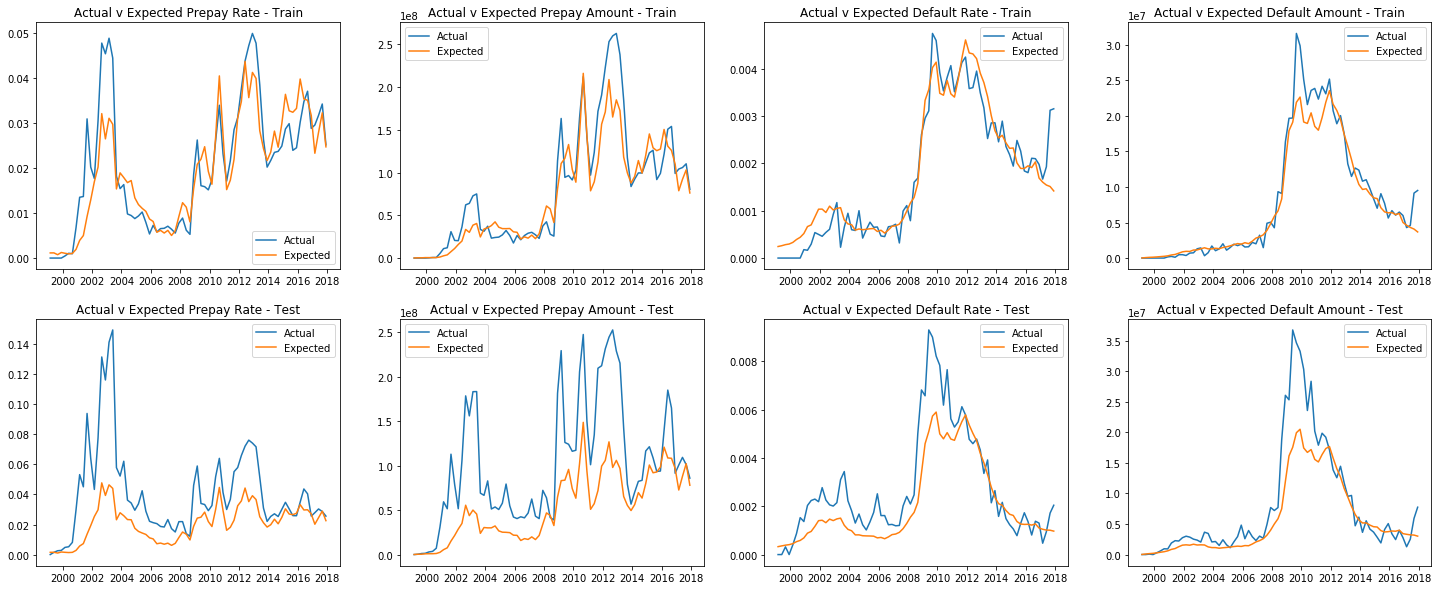

In [102]:
# Fit a model in two steps with a small regularization penalty of 25

reg_penalty=25
a,b,c,d,e,f,g,h,full_model = master_model_fit(10000,reg_penalty)     
assess_model,grouped_model = graph_model(g)

#### Output Model to CSV

In [103]:
model_output = pd.concat((full_model.params.T, full_model.tvalues.T,full_model.bse.T))
model_output.index = np.array(['Coeff Default','Coeff Prepay',
                              'T-Stat Default','T Stat Prepay',
                              'SE Default','SE Prepay'])
model_output

,constant,loan age,credit score,dti,ltv,orig interest rate,Housing Starts,Building Permits,New Home Sales,Existing Home Sales,OECD Leading Indicator YoY,Treasury 1yr,Treasury 30yr,State Unemployment Rate,Real GDP YoY,ZillowHouseValue,30yr Fixed Rate Mortgage Average,SP500 YoY,2_borrowers,loan age squared,loan_age_cubed,30yr_diff,1yr_diff,ZillowHouseChg,State Unemployment Rate Squared,purpose_purchase,purpose_cashout,chan_broker,chan_correspondent,chan_not_specified,Housing Start_diff,Building Permits_diff,New Home Sales_diff,Existing Home Sales_diff,State Unemployment Rate_diff
Coeff Default,-6.923696,1.627408,-0.403331,0.184442,0.414618,0.335710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.269499,0.000000,-0.074929,0.132127,0.000000,0.000000,-0.148415,-1.038471,0.000000,0.110056,-0.104353,-0.328604,0.000000,-0.088065,0.116663,0.058864,0.0,0.042149,0.0,0.000000,0.000000,0.000000,0.265888
Coeff Prepay,-4.235651,2.627997,0.155806,0.016070,0.012961,0.097459,-0.176968,0.619192,0.267236,-0.359583,0.363618,-0.341104,0.111014,0.210396,-0.074460,0.056168,-0.477139,-0.366723,0.129782,-2.838796,0.714876,-0.135958,-0.051039,-0.020682,-0.309260,0.028053,-0.033636,0.019351,0.0,0.000000,0.0,-0.193684,-0.123553,0.275152,0.083179
T-Stat Default,-251.584754,19.214207,-28.371168,11.662803,19.321074,12.607053,NaN,NaN,NaN,NaN,NaN,NaN,-6.766556,NaN,-4.764762,6.983397,NaN,NaN,-9.595457,-14.264885,NaN,3.108187,-4.332278,-14.377817,NaN,-4.295253,6.334138,2.813265,NaN,2.677742,NaN,NaN,NaN,NaN,11.154935
T Stat Prepay,-558.203960,35.942084,27.702034,3.172866,2.352136,9.387179,-4.410044,10.869533,6.193612,-13.723162,30.391295,-17.920165,5.302706,6.028262,-8.006114,9.601122,-19.874824,-33.630126,25.524816,-18.744045,8.125841,-12.068397,-4.847612,-3.013000,-9.191849,4.537137,-5.489577,3.571173,NaN,NaN,NaN,-4.966106,-3.639621,10.633071,6.402744
SE Default,0.027520,0.084698,0.014216,0.015815,0.021459,0.026629,NaN,NaN,NaN,NaN,NaN,NaN,0.039828,NaN,0.015726,0.018920,NaN,NaN,0.015467,0.072799,NaN,0.035408,0.024087,0.022855,NaN,0.020503,0.018418,0.020924,NaN,0.015740,NaN,NaN,NaN,NaN,0.023836
SE Prepay,0.007588,0.073118,0.005624,0.005065,0.005510,0.010382,0.040128,0.056966,0.043147,0.026203,0.011965,0.019035,0.020935,0.034902,0.009300,0.005850,0.024007,0.010905,0.005085,0.151451,0.087976,0.011266,0.010529,0.006864,0.033645,0.006183,0.006127,0.005419,NaN,NaN,NaN,0.039001,0.033947,0.025877,0.012991


In [0]:
model_output.to_csv('/content/drive/My Drive/final_model_output.csv')

#### Numerical Assessment of Model
Calculates the average difference between the actual default rate and the expected default rate

In [0]:
act_def = grouped_model.agg([np.mean])[('prob_def','mean')]
exp_def = grouped_model.agg([np.mean])[('default','mean')]
act_min_exp = act_def-exp_def
act_min_exp = abs(act_min_exp)

In [105]:
print('Average Difference between actual default rate and expected default rate')
print(act_min_exp.mean())

Average Difference between actual default rate and expected default rate
0.0008744757855211965


#### Histogram to assess how model assigns probabilities to mortgages

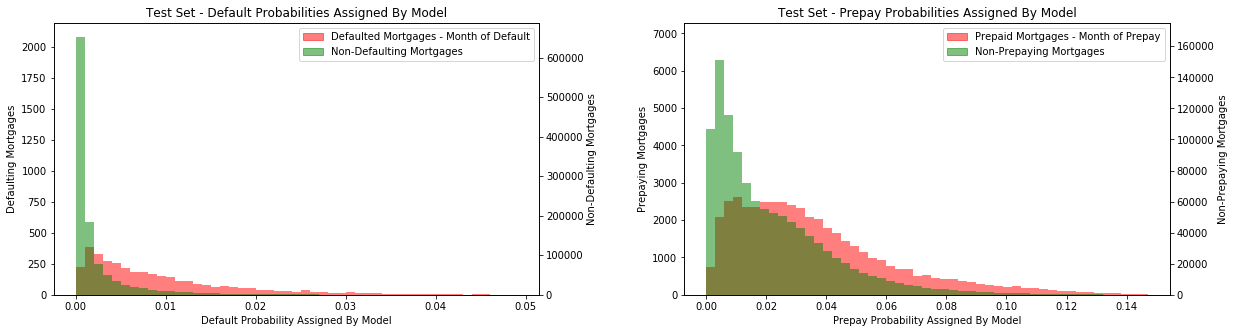

In [106]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 2,figsize=(20, 5))

# Set ylims so they are roughly the same proportion
ax[0].hist(assess_model[assess_model['default']==1]['prob_def'],alpha=.5,color='red',bins=np.arange(0,.05,.001),density=False)
ax[0].grid(False)
ax[0].set_ylabel('Defaulting Mortgages')
ax[0].set_ylim(0,2196)
ax[0].set_xlabel('Default Probability Assigned By Model')
ax2 = ax[0].twinx()
ax2.set_ylim(0,687919)
ax2.hist(assess_model[assess_model['default']==0]['prob_def'],alpha=.5, color='green',bins=np.arange(0,.05,.001),density=False)
ax2.set_ylabel('Non-Defaulting Mortgages')
ax2.set_title('Test Set - Default Probabilities Assigned By Model')
ax2.grid(False)


red_patch = mpatches.Patch(color='red', label='Defaulted Mortgages - Month of Default',alpha=.5)
green_patch = mpatches.Patch(color='green', label='Non-Defaulting Mortgages',alpha=.5)
ax[0].legend(handles=[red_patch,green_patch])

ax[1].hist(assess_model[assess_model['prepay']==1]['prob_pre'],alpha=.5,color='red',bins=np.arange(0,.15,.003),density=False)
ax[1].grid(False)
ax[1].set_ylim(0,7278)
ax[1].set_ylabel('Prepaying Mortgages')
ax[1].set_xlabel('Prepay Probability Assigned By Model')

ax3 = ax[1].twinx()
ax3.set_ylim(0,175000)
ax3.hist(assess_model[assess_model['prepay']==0]['prob_pre'],alpha=.5, color='green',bins=np.arange(0,.15,.003),density=False)
ax3.set_ylabel('Non-Prepaying Mortgages')
ax3.set_title('Test Set - Prepay Probabilities Assigned By Model')
ax3.grid(False)


red_patch = mpatches.Patch(color='red', label='Prepaid Mortgages - Month of Prepay',alpha=.5)
green_patch = mpatches.Patch(color='green', label='Non-Prepaying Mortgages',alpha=.5)
ax[1].legend(handles=[red_patch,green_patch])

fig.subplots_adjust(wspace=.3)

plt.show()

In [107]:
print(assess_model[assess_model['prepay']==1]['prob_pre'].shape)
print(assess_model[assess_model['prepay']==0]['prob_pre'].shape)

(45930,)
(1104263,)


#### Default Curves for Different Vintages

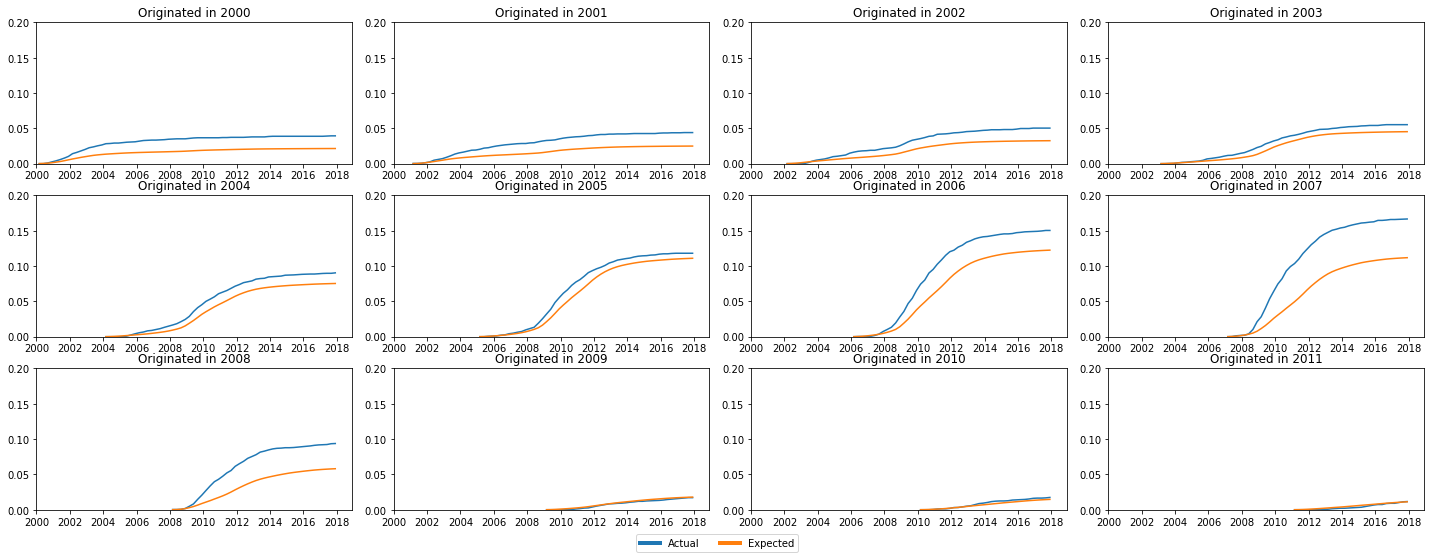

In [108]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(3, 4,figsize=(20, 8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

potential_years = ['00','01','02','03','04','05','06','07','08','09','10','11']

for i in range(12):
  row = i//4
  col = i%4
  
  indicies_year = data_all_test[data_all_test['loan seq num'].astype(str).str[2:4]==potential_years[i]].index
  assess_year = assess_model.loc[indicies_year]
  num_loans_year = data_all_test.loc[assess_year.index]['loan seq num'].unique().shape[0]
  
  grouped_year = assess_year.groupby('period')
  cumsum_def_year = grouped_year[['default','prob_def']].agg([np.sum])/num_loans_year
  cumsum_def_year = cumsum_def_year.cumsum()
  
  datemin = np.datetime64(2000, 'Y')
  ax[row,col].set_xlim(datetime.date(2000, 1, 1),datetime.date(2018, 12, 5) )
  ax[row,col].set_ylim(0,.2)
  
  ax[row,col].plot(cumsum_def_year['default'])
  ax[row,col].plot(cumsum_def_year['prob_def'])
  ax[row,col].set_title('Originated in 20'+potential_years[i])
 

legend_lines = [Line2D([0], [0], color='C0', lw=4),
                Line2D([0], [0], color='C1', lw=4)]
plt.figlegend(legend_lines,('Actual', 'Expected'),'lower center',ncol=2,fontsize='medium')
  
plt.show()

#### Appendix
Some extra code on how to code up a custom model with custom alpha penalties

In [0]:
def custom_model(custom_alpha_penalty,alpha_small_penalty,alpha_large_penalty):
  
  # transform training variables
  X_MN,y_MN,mn_vars,alpha_penalty = setup_MN_variables('train',0,0)
  
  # fit model
  mdl_fit = run_MN_regression(X_MN,y_MN,custom_alpha_penalty)
  
  # train/test log_likelihoods
  train_avg_ll = mdl_fit.llf/X_MN.shape[0]
  
  # transform testing variables
  X_MN,y_MN,mn_vars,alpha_penalty = setup_MN_variables('test',alpha_large_penalty,alpha_small_penalty)
  
  # test log likelihood
  test_avg_ll = calc_avg_log_like(mdl_fit,y_MN,X_MN)
  
  return train_avg_ll, test_avg_ll, mdl_fit.params, mdl_fit.tvalues, mdl_fit
  

In [0]:
large_penalty = 10000
small_penalty = 25

# David's Initial Regularization - INITIAL KILL VARIABLES NOT INTUITIVELY USEFUL
custom_alpha_penalty = np.concatenate((np.array([0]),
                                 np.array([small_penalty,small_penalty,small_penalty,small_penalty,large_penalty,
                                           large_penalty,small_penalty,large_penalty,small_penalty,large_penalty,
                                           large_penalty,large_penalty,small_penalty,small_penalty,large_penalty,
                                           large_penalty,small_penalty,small_penalty,small_penalty,small_penalty,
                                           large_penalty,large_penalty,small_penalty,small_penalty,small_penalty,
                                           small_penalty,small_penalty,small_penalty,small_penalty,large_penalty,
                                           large_penalty,large_penalty,large_penalty,large_penalty]))) # penalty for default variables
custom_alpha_penalty = np.concatenate((custom_alpha_penalty,np.array([0]),
                                 np.array([small_penalty,small_penalty,small_penalty,small_penalty,large_penalty,
                                           large_penalty,small_penalty,small_penalty,small_penalty,large_penalty,
                                           large_penalty,large_penalty,small_penalty,small_penalty,large_penalty,
                                           large_penalty,small_penalty,small_penalty,small_penalty,small_penalty,
                                           small_penalty,large_penalty,small_penalty,small_penalty,small_penalty,
                                           small_penalty,small_penalty,small_penalty,small_penalty,large_penalty,
                                           large_penalty,large_penalty,large_penalty,large_penalty]))) # penalty for prepay variables

trainll,testll, params, ts, mdlfit = custom_model(custom_alpha_penalty,small_penalty,large_penalty)
print(trainll,testll)

g = graph_model(params)